In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized_bio_sensor/rockley

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1EaHvULJYewcfEpQ7wlYgmG1eRbVcahUv/optimized_bio_sensor/rockley


In [ ]:
import utils.data as data_loader
 
train, val, test = data_loader.load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=64,
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Function for mean squared error just to make sure its computing correctly
def calculate_mse(Y1, Y2):
  return np.mean((Y1 - Y2) ** 2)

In [ ]:
# Take a subset to speed up training
# Also reshape Y for PyTorch MSELoss
Xsub_train, Ysub_train = Xtrain[:10000], Ytrain[:10000].reshape((-1, 1))

0.24837233583347687
3472687667.170824


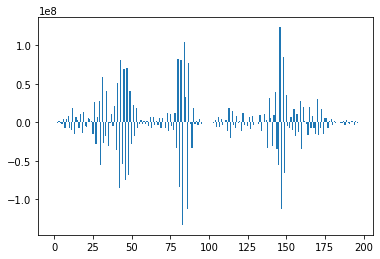

In [ ]:
import sklearn.linear_model
import sklearn

# Check what true solution is
mod = sklearn.linear_model.LinearRegression()
mod.fit(Xsub_train, Ysub_train[:, 0])
print(calculate_mse(mod.predict(Xsub_train), Ysub_train[:, 0]))
# Total sum of absolute weights is at the level of 10^6
print(np.sum(np.abs(mod.coef_)))
plt.bar([x for x in range(len(mod.coef_))], mod.coef_)
plt.show()

In [ ]:
print(calculate_mse(mod.predict(Xval), Yval))

7.834816080888441e-05


In [ ]:
print(mod.predict(Xval))

[-0.00358213 -1.67264729  1.12935034 ... -0.98669692  0.52659567
 -0.73953469]


In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        # self.net = nn.Sequential([
        #     nn.Linear(input_size, 1)
        # ])
        # def init_weights(m):
        #     if isinstance(m, nn.Linear):
        #         m.weight.data.fill_(mod.coef_)
        #         torch.nn.init.xavier_uniform(m.weight)
        #         m.bias.data.fill_(0.01)
        self.layer = nn.Linear(input_size, 1, dtype=torch.float64)

        # Start near true solution, it converges to that if placed near
        # self.layer.weight.data = torch.from_numpy(mod.coef_ + np.random.rand(input_size) * 0).unsqueeze(0)
        # self.layer.bias.data = torch.from_numpy(mod.intercept_ + np.random.rand(1) * 0)
        # self.layer.weight.data = prev_model.layer.weight.data
        # self.layer.bias.data = prev_model.layer.bias.data

    def forward(self, measurements_selected):
        # print(self.layer.weight.data - mod.coef_)
        out = self.layer(measurements_selected)
        return out

In [ ]:
model = LinearRegression(197)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

l = 0
k = 70

weights = []
losses = []
epoch = 0
prev_idxs = torch.from_numpy(np.array([range(0, k)]))

# Converting inputs and labels to Variable
inputs = torch.from_numpy(Xsub_train)
labels = torch.from_numpy(Ysub_train)
while True:

    # get output from the model, given the inputs
    outputs = model(inputs)

    # clear built-up gradients
    optimizer.zero_grad()

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    
    # Add L1 Norm regularization term
    total_loss = loss + l * torch.sum(model.layer.weight.abs())
    # get gradients w.r.t to parameters
    total_loss.backward()

    # update parameters
    optimizer.step()

    vals, idx = torch.abs(model.layer.weight.data).topk(k)
    new_weights = torch.zeros_like(model.layer.weight.data)
    new_weights[:, idx[0]] = model.layer.weight.data[:, idx[0]]
    model.layer.weight.data = new_weights

    if epoch % 10000 == 0:
      diff = 0
      s1 = set(idx[0].tolist())
      s2 = set(prev_idxs[0].tolist())
      for s in s1:
        if s not in s2:
          diff += 1
      prev_idxs = idx
      print('epoch {}, loss {}, diff {}'.format(epoch, loss.item(), diff))
      if losses and abs(losses[-1] - loss.item()) <= 1e-3:
        break
      losses.append(loss.item())
    epoch += 1

plt.plot(losses)
plt.show()

epoch 0, loss 13164.478288433396, diff 40
epoch 10000, loss 1429.6991843861135, diff 35
epoch 20000, loss 655.2647017344254, diff 10
epoch 30000, loss 356.41780679128686, diff 3
epoch 40000, loss 228.2535774606979, diff 2
epoch 50000, loss 166.3003852844514, diff 1
epoch 60000, loss 132.90991366552828, diff 0
epoch 70000, loss 112.20976328335165, diff 1
epoch 80000, loss 98.93322750230696, diff 1
epoch 90000, loss 89.54203875298906, diff 1
epoch 100000, loss 82.76458250431907, diff 1
epoch 110000, loss 78.07679144435437, diff 0
epoch 120000, loss 74.80918425829203, diff 0
epoch 130000, loss 72.46211319164881, diff 0
epoch 140000, loss 70.73202625002813, diff 0
epoch 150000, loss 69.41431360137993, diff 0
epoch 160000, loss 68.39210354503976, diff 1
epoch 170000, loss 67.58552798593433, diff 0
epoch 180000, loss 66.9384247519874, diff 0
epoch 190000, loss 66.40116458088127, diff 0
epoch 200000, loss 65.94584898498428, diff 0
epoch 210000, loss 65.57843646621257, diff 0
epoch 220000, los

KeyboardInterrupt: ignored

In [ ]:

print(calculate_mse(model(torch.from_numpy(Xval)).detach().numpy(), Yval.reshape(-1, 1)))
print(model(torch.from_numpy(Xval)).detach().numpy())

57.49534511178887
[[100.42223111]
 [ 25.21287693]
 [163.88581371]
 ...
 [ 48.11876543]
 [128.98964493]
 [ 56.80273557]]


tensor([[  74.4363,    0.0000,  169.2506,    0.0000,  139.6184,  594.6636,
          876.0143,  898.0406,  777.4304,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000,   61.6204,
          619.1851,  830.5707,  607.2450,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
          671.6254,  656.7470,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,  172.6397,  157.1411,  224.2349,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,  751.8110,  729.2045,    0.0000,  873.5240,  282.9598,
          656.6588,  521.6854,    0.0000,    0.0000,    0.0000,    0.0000,
         1082.1692,  666.5916,    0.0000,    0.0000,  866.3478,  984.6144,
            0.0000,    0.0000,    0.0000, 1069.0557,  874.6668, 1027.2312,
          967.0959,    0.

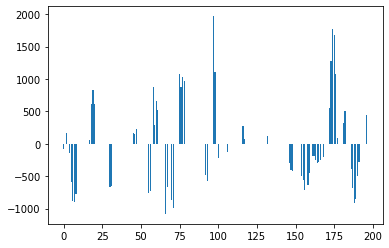

In [ ]:
# Total sum of absolute weights is at the level of 10^4
print(model.layer.weight.abs())
print(torch.sum(model.layer.weight.abs()).item())
print(torch.sum(model.layer.weight!=0))

weights = model.layer.weight.detach().numpy()[0]
plt.bar([x for x in range(len(weights))], weights)
plt.show()

In [ ]:
idxs = []
for i in range(197):
  if model.layer.weight.data[0, i] != 0:
    idxs.append(i) 
print(idxs)

[0, 2, 4, 5, 6, 7, 8, 17, 18, 19, 20, 30, 31, 45, 46, 47, 55, 56, 58, 59, 60, 61, 66, 67, 70, 71, 75, 76, 77, 78, 92, 93, 97, 98, 100, 101, 106, 116, 117, 132, 146, 147, 148, 154, 155, 156, 158, 159, 161, 162, 163, 164, 165, 166, 168, 172, 173, 174, 175, 176, 177, 181, 182, 186, 187, 188, 189, 190, 191, 196]


1.4347607174040822
37708979.70973394


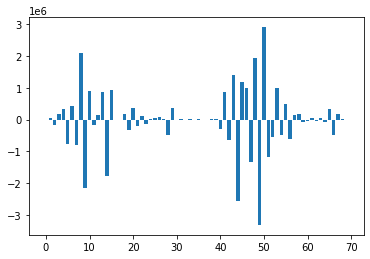

[-7.97393917e+03  4.20547740e+04 -1.84092652e+05  1.80063863e+05
  3.25468413e+05 -7.63040217e+05  4.40314280e+05 -7.98920230e+05
  2.08359998e+06 -2.17030079e+06  8.86831269e+05 -1.86791170e+05
  1.50414755e+05  8.72328284e+05 -1.76823109e+06  9.17681692e+05
 -2.16152335e+04 -1.73963212e+04  1.73827550e+05 -3.31856665e+05
  3.60940737e+05 -2.18167360e+05  1.25846972e+05 -1.28897212e+05
  1.50479882e+04  4.55154915e+04  9.48057591e+04  2.72485294e+04
 -5.02887690e+05  3.66904439e+05 -1.00793837e+04  6.10407122e+03
 -8.20573449e+03  9.30645905e+03 -2.85506025e+03  9.40069236e+02
  2.57688723e+02 -5.39324848e+03  5.79005967e+03  1.22614949e+03
 -3.03534662e+05  8.62724703e+05 -6.60017477e+05  1.40591944e+06
 -2.57455991e+06  1.17986689e+06  9.87487206e+05 -1.35112713e+06
  1.95060014e+06 -3.32123666e+06  2.90758291e+06 -1.18566839e+06
 -5.36627316e+05  9.96753940e+05 -4.74389203e+05  4.94946553e+05
 -6.04825377e+05  1.30732728e+05  1.77463295e+05 -7.13457119e+04
 -5.04480641e+04  5.59134

In [ ]:
import sklearn.linear_model
import sklearn

# Check what true solution is
mod = sklearn.linear_model.LinearRegression()
mod.fit(Xsub_train[:, idxs], Ysub_train[:, 0])
print(calculate_mse(mod.predict(Xval[:, idxs]), Yval))
# Total sum of absolute weights is at the level of 10^6
print(np.sum(np.abs(mod.coef_)))
plt.bar([x for x in range(len(mod.coef_))], mod.coef_)
plt.show()
print(mod.coef_)

0.0004283993831758332
651597.57826748


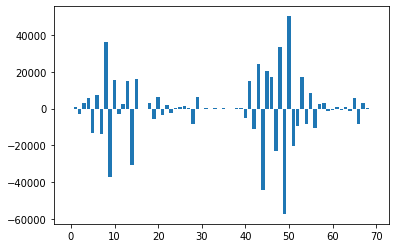

[-1.37786795e+02  7.26691337e+02 -3.18105467e+03  3.11143865e+03
  5.62397687e+03 -1.31850599e+04  7.60847205e+03 -1.38050536e+04
  3.60038567e+04 -3.75020153e+04  1.53241247e+04 -3.22768409e+03
  2.59911275e+03  1.50735183e+04 -3.05543959e+04  1.58572089e+04
 -3.73503444e+02 -3.00602160e+02  3.00367742e+03 -5.73436357e+03
  6.23692585e+03 -3.76985335e+03  2.17459031e+03 -2.22729737e+03
  2.60023813e+02  7.86491288e+02  1.63820935e+03  4.70844767e+02
 -8.68971803e+03  6.33997647e+03 -1.74168117e+02  1.05476151e+02
 -1.41792134e+02  1.60812258e+02 -4.93344121e+01  1.62440576e+01
  4.45276825e+00 -9.31933899e+01  1.00050144e+02  2.11874213e+01
 -5.24496956e+03  1.49075719e+04 -1.14048641e+04  2.42937812e+04
 -4.44874674e+04  2.03876747e+04  1.70634230e+04 -2.33469897e+04
  3.37056674e+04 -5.73897725e+04  5.02419848e+04 -2.04879224e+04
 -9.27272661e+03  1.72235488e+04 -8.19727445e+03  8.55249805e+03
 -1.04511645e+04  2.25901443e+03  3.06650177e+03 -1.23282819e+03
 -8.71724365e+02  9.66164

In [ ]:
import sklearn.linear_model
import sklearn

# Check what true solution is
mod = sklearn.linear_model.LinearRegression()
Ym, Ystd = np.mean(Ysub_train, axis=0), np.std(Ysub_train, axis=0)
mod.fit(Xsub_train[:, idxs], (Ysub_train[:, 0] - Ym) / Ystd)
print(calculate_mse(mod.predict(Xval[:, idxs]), (Yval - Ym) / Ystd))
# Total sum of absolute weights is at the level of 10^6
print(np.sum(np.abs(mod.coef_)))
plt.bar([x for x in range(len(mod.coef_))], mod.coef_)
plt.show()
print(mod.coef_)

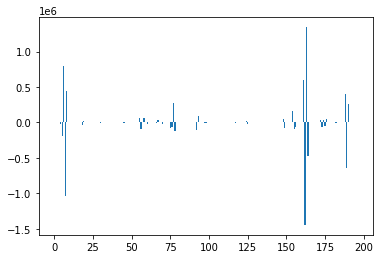

In [ ]:
weights = []
cnt = 0
for i in range(197):
  if model.layer.weight.data[0, i] != 0:
    weights.append(mod.coef_[cnt])
    cnt += 1
  else:
    weights.append(0)
plt.bar([x for x in range(len(weights))], weights)
plt.show()

[-1923.1461696264903, 0, 0, 0, 57507.9118536355, -240530.85331473968, 329001.2928506328, -146502.18836323495, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30200.919365277154, -30091.237746266215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 83520.42351748115, -89616.53327379673, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17648.891898585312, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6075.535858261194, -11655.647977394405, 0, 0, 0, 56375.025291815226, -45168.5323834603, 0, 0, 0, 44935.055298574196, -68120.90506556699, 0, 0, 132161.4445598571, -123039.7148744194, 0, 0, 0, 0, -70160.40437879533, 0, 371987.2363753351, -305527.73747181497, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22084.43580460845, 0, 0, -2235.9263886722038, 0, -6311.752727846198, 461.56721689205864, 0, 0, -67.76422627279717, 0, 0, 0, 0, 0, 24.346816119474266, 0, 0, 0, 0, 0, 0, 0, 0, -1383.1258163758648, 1721.7038247070964, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 311.88867881964876, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14336.631613621874, -38019.187914535665, 0, 0

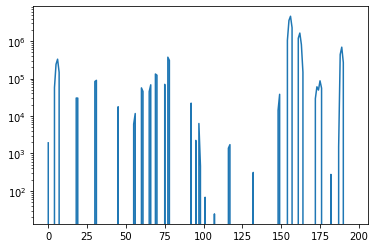

In [ ]:
print(weights)
plt.plot([x for x in range(len(weights))], np.abs(weights))
plt.yscale('log')
plt.show()

In [ ]:
prev_model = model